In [1]:
# import the required libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
# Global Variables for later use

IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
# There are 1289 Total Images in our dataset 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/",
    seed=123, # this will ensure we get the same images each time
    shuffle=True, # images inside the batches will be shuffled
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # every image will be of 128x128x3 dimention
    batch_size=BATCH_SIZE # There will be 32 images in each batch
)

Found 1289 files belonging to 2 classes.


In [4]:
# The Images belong to the following Class Labels

class_names = dataset.class_names
class_names

['fake', 'real']

In [5]:
# Let's see how the images are distributed inside a batch
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1]


## Exploring the Images inside the Dataset

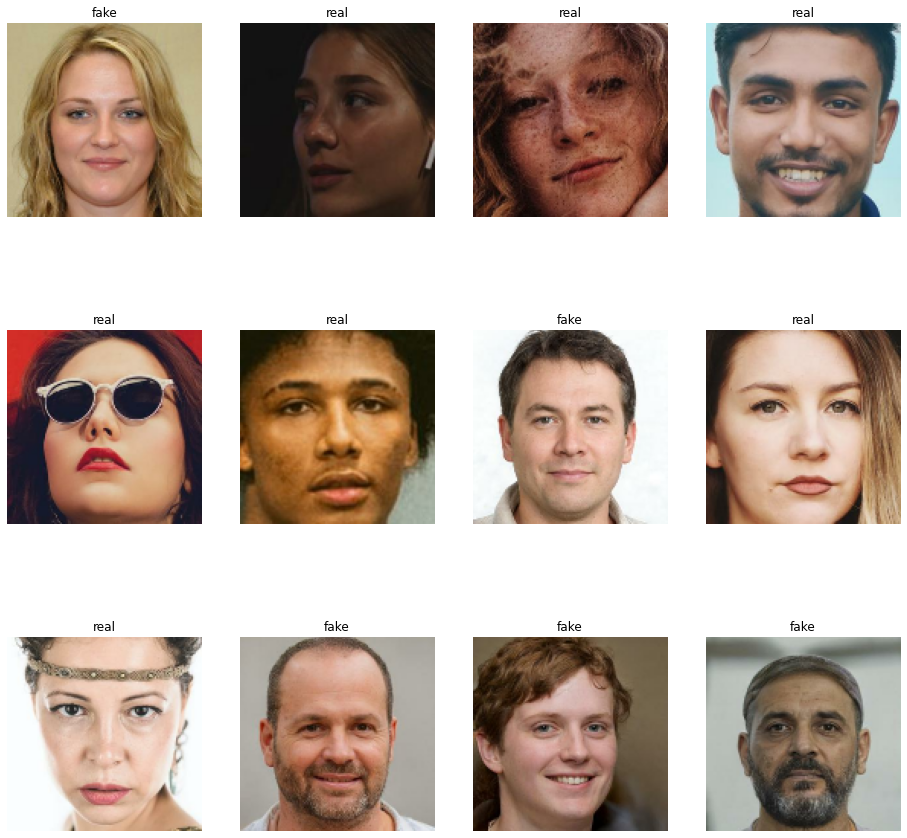

In [29]:
plt.figure(figsize=(16, 16))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.axis("off")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])

## Splitting the dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [7]:
# we have 41 batches of data
len(dataset)

41

In [8]:
train_size = 0.80
len(dataset)*train_size

32.800000000000004

In [9]:
train_ds = dataset.take(32)
len(train_ds)

32

In [10]:
test_ds = dataset.skip(32)
len(test_ds)

9

In [11]:
val_size = 0.5
len(test_ds)*val_size

4.5

In [12]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [13]:
test_ds = test_ds.skip(4)
len(test_ds)

5

## Cache, Shuffle, and Prefetch the Dataset for faster training

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Image Augmentation
Augmentation is the process of creating new training samples by altering the available data. <br>
It not only increases the number of samples for training the model but also prevents the model from overfitting the training data since it makes relevant feautes in the image location invariant. <br>

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
# Applying Augmentation on Training Data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Designing and Training the Model

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    resize_and_rescale,
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization
    
    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [19]:
model.build(input_shape=input_shape)

In [20]:
# There are 1.1 Million Traininable Parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 127, 127, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 31, 31, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 31, 31, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 10, 10, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 10, 10, 64)         

In [21]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [22]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights.h5", verbose=1, save_best_only=True)

In [23]:
history = model.fit(train_ds, epochs = 100, validation_data=val_ds, batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5400
Epoch 1: val_loss improved from inf to 0.68255, saving model to fakevsreal_weights.h5
32/32 [==============================] - 12s 104ms/step - loss: 0.6951 - accuracy: 0.5400 - val_loss: 0.6825 - val_accuracy: 0.5938
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5527
Epoch 2: val_loss did not improve from 0.68255
32/32 [==============================] - 3s 81ms/step - loss: 0.6850 - accuracy: 0.5527 - val_loss: 0.6873 - val_accuracy: 0.5938
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5537
Epoch 3: val_loss improved from 0.68255 to 0.65501, saving model to fakevsreal_weights.h5
32/32 [==============================] - 3s 83ms/step - loss: 0.6840 - accuracy: 0.5537 - val_loss: 0.6550 - val_accuracy: 0.5938
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.6230
Epoch

Epoch 29/100
32/32 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9629
Epoch 29: val_loss did not improve from 0.06701
32/32 [==============================] - 3s 81ms/step - loss: 0.0920 - accuracy: 0.9629 - val_loss: 0.0693 - val_accuracy: 0.9766
Epoch 30/100
32/32 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9727
Epoch 30: val_loss did not improve from 0.06701
32/32 [==============================] - 3s 82ms/step - loss: 0.0965 - accuracy: 0.9727 - val_loss: 0.1035 - val_accuracy: 0.9688
Epoch 31/100
32/32 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9736
Epoch 31: val_loss did not improve from 0.06701
32/32 [==============================] - 3s 81ms/step - loss: 0.0876 - accuracy: 0.9736 - val_loss: 0.1087 - val_accuracy: 0.9609
Epoch 32/100
32/32 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9756
Epoch 32: val_loss did not improve from 0.06701
32/32 [===========================

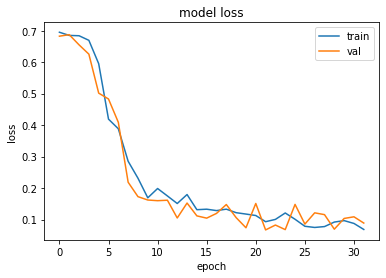

In [24]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

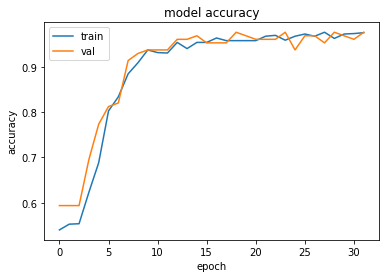

In [25]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [27]:
# Load pretrained model (best saved one)
with open('fakevsreal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('fakevsreal_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [28]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 1s 86ms/step - loss: 0.0881 - accuracy: 0.9562
